**Curso de Inteligencia Artificial y Aprendizaje Profundo**


# Análisis de sentimiento a partir de comentarios de películas

##  Autores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Oleg Jarma, ojarmam@unal.edu.co
4. Maria del Pilar Montenegro, pmontenegro88@gmail.com

## Referencias

1. Basado en el blog de laurencemoroney: (https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt)

## Contenido

* [Introducción](#Introducción)
* [Datos](#Datos)
* [Preprocesamiento](#Preprocesamiento)
* [Librerías](#Librerías)
* [Lee los datos](#Lee-los-datos)
* [Tokeniza el texto](#Lee-los-datos)
* [Crea n-Grams para datos de entrenamiento y etiquetas](#Crea-n-Grams-para-datos-de-entrenamiento-y-etiquetas)
* [Crea-el-modelo](#Crea-el-modelo)
* [Genera-texto-automáticamente](#Genera-texto-automáticamente)

In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.1.0


## Introducción


Gran conjunto de datos basado en sonetos de Shekespeare.


## Librerías


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import numpy as np 

import tensorflow as tf

from tensorflow.keras.utils import plot_model

## Lee los datos

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

--2020-10-17 15:53:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.173.208, 216.58.222.240, 172.217.28.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.173.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91,38K  --.-KB/s    in 0,02s   

2020-10-17 15:53:20 (4,84 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



## Tokeniza el texto


In [5]:
tokenizer = Tokenizer()

corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

#print('Dictionary: ',tokenizer.word_index,'\n')
print('index of rage = ',tokenizer.word_index['rage'])
print('\nTotal Words in the Tokenizer (+OOV) =',total_words,'\n')

# Show Part of Corpus
print('First lines of the Corpus: \n')
corpus[0:10]

index of rage =  443

Total Words in the Tokenizer (+OOV) = 3211 

First lines of the Corpus: 



['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

## Crea n-Grams para datos de entrenamiento y etiquetas


In [6]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        
print('input_sequences[0:10] = ',input_sequences[:10],'\n')

# Determine longest n-gram
max_seq_test_len = max([len(x) for x in input_sequences])
print('\nlong. n-grama más largo:',max_seq_test_len)


input_sequences[0:10] =  [[34, 417], [34, 417, 877], [34, 417, 877, 166], [34, 417, 877, 166, 213], [34, 417, 877, 166, 213, 517], [8, 878], [8, 878, 134], [8, 878, 134, 351], [8, 878, 134, 351, 102], [8, 878, 134, 351, 102, 156]] 


long. n-grama más largo: 11


In [7]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = to_categorical(label, num_classes=total_words)

## Crea el modelo


In [8]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

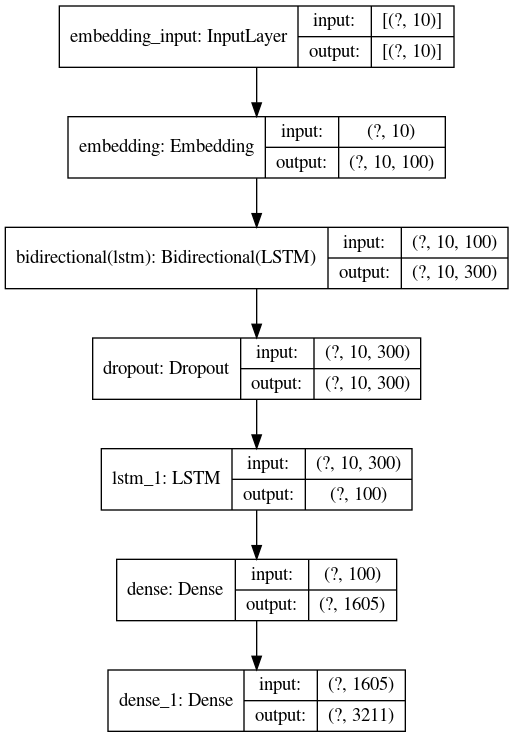

In [9]:
print(model.summary())
plot_model(model, to_file='../Imagenes/sonetos.png', 
           show_shapes=True)

## Entrena

In [10]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 124s 8ms/sample - loss: 6.9038 - accuracy: 0.0216
Epoch 2/100
15462/15462 [==============================] - 113s 7ms/sample - loss: 6.5005 - accuracy: 0.0227
Epoch 3/100
15462/15462 [==============================] - 104s 7ms/sample - loss: 6.4022 - accuracy: 0.0240
Epoch 4/100
15462/15462 [==============================] - 130s 8ms/sample - loss: 6.2774 - accuracy: 0.0270
Epoch 5/100
15462/15462 [==============================] - 126s 8ms/sample - loss: 6.1789 - accuracy: 0.0349
Epoch 6/100
15462/15462 [==============================] - 89s 6ms/sample - loss: 6.0936 - accuracy: 0.0380
Epoch 7/100
15462/15462 [==============================] - 91s 6ms/sample - loss: 6.0174 - accuracy: 0.0416
Epoch 8/100
15462/15462 [==============================] - 90s 6ms/sample - loss: 5.9288 - accuracy: 0.0453
Epoch 9/100
15462/15462 [==============================] - 90s 6ms/sample - loss: 5.8338 - accuracy: 0.0519


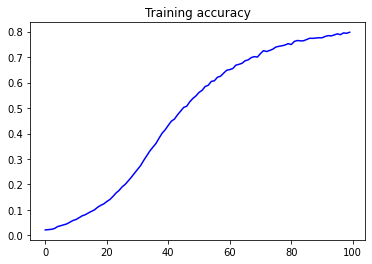

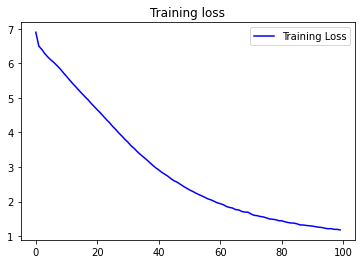

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## Genera texto automáticamente

In [12]:
seed_text = "Who are you, so too cruel?"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Who are you, so too cruel? in you have free tend show thee me heaven dead deem'd lie on her long alone must not must strive to write self hue most scope still true shown pride words behold old hate old part my view you are pride prove me 'no new prove be worth and thee doth tender'd made write you bright 'no new part me young me old write for me i love not thought thy sight must new must find torn clears dyed new breast lack where how to thee now swearing write old love me prove me write old for thee in thee
